In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

In [ ]:
df = pd.read_csv('./stack-overflow-survey-2022.csv')
df_len = len(df)

In [ ]:
not_null = df['MentalHealth'].notna()
not_none = df['MentalHealth'] != 'None of the above'
not_not_say = df['MentalHealth'] != 'Prefer not to say'
df_mh = df.loc[not_null & not_none & not_not_say]

is_full_time = df_mh['Employment'] == 'Employed, full-time'
has_pro_year = df_mh['YearsCodePro'].notna()
df_mh_pro = df_mh.loc[is_full_time & has_pro_year]

df_mh_pro_len = len(df_mh_pro)

In [ ]:
def get_mental_health_stats(mental_health=None):
  if mental_health == None:
    df_stats_len = df_mh_pro_len
  else:
    df_stats_len = df_mh_pro['MentalHealth'].str.contains(mental_health, case=False).sum()
  
  df_stats_prop = df_stats_len / df_len
  df_stats_err = proportion_confint(df_stats_len, df_len)
  df_stats_err = df_stats_err[1] - df_stats_err[0]
  return df_stats_prop, df_stats_err

In [ ]:
df_mh_pro_plot = pd.DataFrame(columns=['issue_type', 'prop', 'prop_err'])

In [ ]:
df_dep_prop, df_dep_err = get_mental_health_stats('depression')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Depression', df_dep_prop, df_dep_err]

In [ ]:
df_anx_prop, df_anx_err = get_mental_health_stats('anxiety')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Anxiety', df_anx_prop, df_anx_err]

In [ ]:
df_mh_pro_prop, df_mh_pro_err = get_mental_health_stats('adhd')
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['ADHD', df_mh_pro_prop, df_mh_pro_err]

In [ ]:
df_adhd_prop, df_adhd_err = get_mental_health_stats()
df_mh_pro_plot.loc[len(df_mh_pro_plot)] = ['Overall', df_adhd_prop, df_adhd_err]

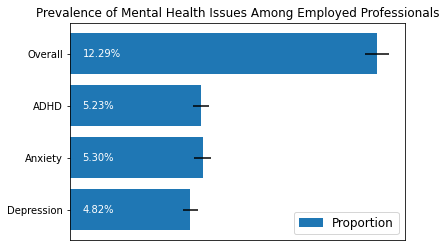

In [ ]:
plt.barh(df_mh_pro_plot['issue_type'], df_mh_pro_plot['prop'], xerr=df_mh_pro_plot['prop_err'])
plt.title('Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion', 'Err'], fontsize=12, loc='lower right')
plt.xticks([], [])

for i, v in enumerate(df_mh_pro_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

In [ ]:
df_c_plot = df_mh_pro['Country'].value_counts()[:30].to_frame()
df_c_plot.reset_index(inplace=True)
df_c_plot.columns = ['country_name', 'total_mh_samples']

df_top_30 = df[df['Country'].isin(df_c_plot['country_name'])]
total_samples_by_country = df_top_30.groupby('Country').size()
df_c_plot['total_samples'] = df_c_plot['country_name'].map(total_samples_by_country).fillna(0)

df_c_plot['prop'] = df_c_plot['total_mh_samples'] / df_c_plot['total_samples']
df_c_plot = df_c_plot.sort_values('prop').reset_index(drop=True)

In [ ]:
confidence_lvl_c = proportion_confint(df_c_plot['total_mh_samples'], df_c_plot['total_samples'])
df_c_plot['conf_lo'] = confidence_lvl_c[0]
df_c_plot['conf_hi'] = confidence_lvl_c[1]
df_c_plot['conf_error'] = confidence_lvl_c[1] - confidence_lvl_c[0]

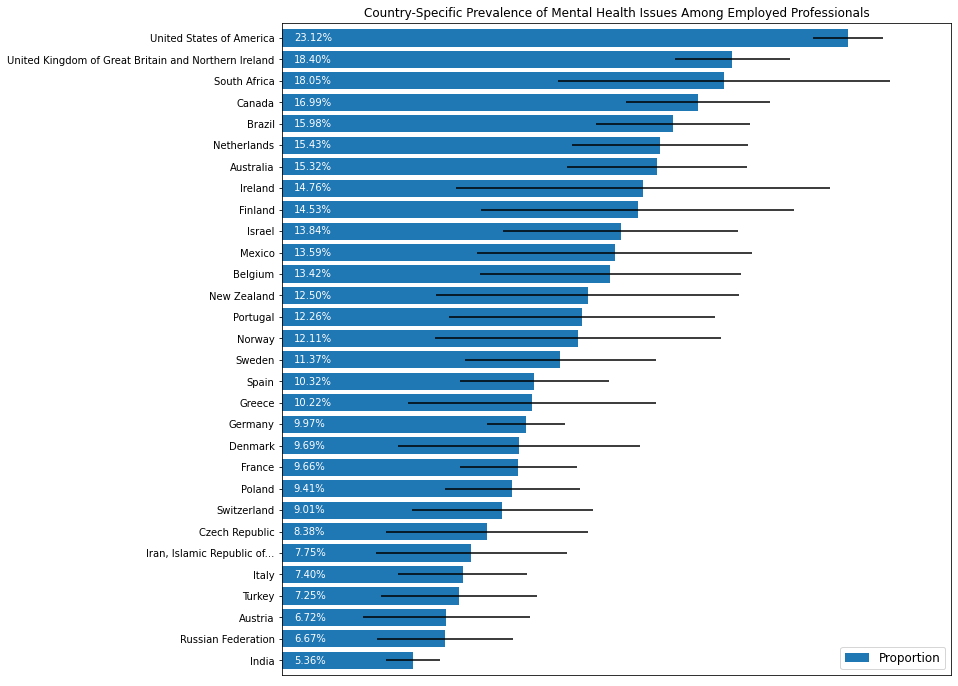

In [ ]:
plt.figure(figsize=(12,12))
plt.barh(df_c_plot['country_name'], df_c_plot['prop'], xerr=df_c_plot['conf_error'])
plt.title('Country-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])
plt.margins(.1, .01)

for i, v in enumerate(df_c_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

In [ ]:
def get_remote_stats(mental_type):
  df_remote_len = df_mh_pro[df_mh_pro['RemoteWork'] == mental_type].shape[0]
  df_remote_prop = df_remote_len / df_mh_pro_len
  df_remote_err = proportion_confint(df_remote_len, df_mh_pro_len)
  df_remote_err = df_remote_err[1] - df_remote_err[0]
  return df_remote_prop, df_remote_err

In [ ]:
df_wm_plot = pd.DataFrame(columns=['remote_type', 'prop', 'prop_err'])

In [ ]:
df_inperson_prop, df_inperson_prop_err = get_remote_stats('Full in-person')
df_wm_plot.loc[len(df_wm_plot)] = ['In-Person', df_inperson_prop, df_inperson_prop_err]

In [ ]:
df_hybrid_prop, df_hybrid_prop_err = get_remote_stats('Hybrid (some remote, some in-person)')
df_wm_plot.loc[len(df_wm_plot)] = ['Hybrid', df_hybrid_prop, df_hybrid_prop_err]

In [ ]:
df_remote_prop, df_remote_prop_err = get_remote_stats('Fully remote')
df_wm_plot.loc[len(df_wm_plot)] = ['Remote', df_remote_prop, df_remote_prop_err]

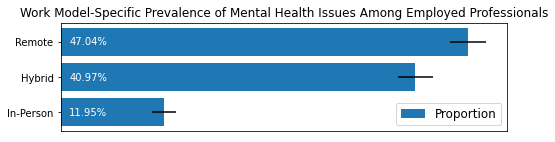

In [ ]:
plt.figure(figsize=(8,2))
plt.barh(df_wm_plot['remote_type'], df_wm_plot['prop'], xerr=df_wm_plot['prop_err'])
plt.title('Work Model-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])

for i, v in enumerate(df_wm_plot['prop']):
  plt.text(.01, i, f'{v*100:.2f}%', color='white', va='center')

In [ ]:
df_dt = df[df['DevType'].notna()]
df_dt = df_dt['DevType'].str.split(';').explode()
df_dt_counts = df_dt.value_counts()

df_mh_pro_dt = df_mh_pro[df_mh_pro['DevType'].notna()]
df_mh_pro_dt = df_mh_pro_dt['DevType'].str.split(';').explode()
df_mh_pro_dt_counts = df_mh_pro_dt.value_counts()

df_dv_plot = pd.concat([df_mh_pro_dt_counts, df_dt_counts], axis=1)
df_dv_plot.reset_index(inplace=True)
df_dv_plot.columns = ['dev_type', 'total_mh_samples', 'total_samples']

In [ ]:
df_dv_plot['prop'] = df_dv_plot['total_mh_samples'] / df_dv_plot['total_samples']
df_dv_plot = df_dv_plot.sort_values('prop').reset_index(drop=True)

In [ ]:
confidence_lvl_dv = proportion_confint(df_dv_plot['total_mh_samples'], df_dv_plot['total_samples'])
df_dv_plot['conf_lo'] = confidence_lvl_dv[0]
df_dv_plot['conf_hi'] = confidence_lvl_dv[1]
df_dv_plot['conf_error'] = confidence_lvl_dv[1] - confidence_lvl_dv[0]

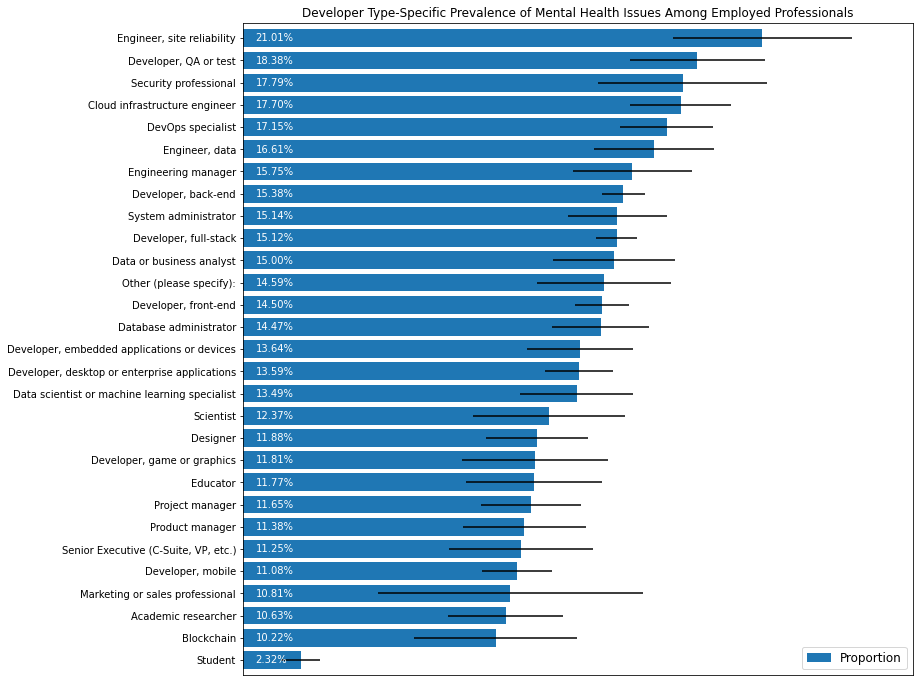

In [ ]:
plt.figure(figsize=(12,12))
plt.barh(df_dv_plot['dev_type'], df_dv_plot['prop'], xerr=df_dv_plot['conf_error'])
plt.title('Developer Type-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.legend(['Proportion'], fontsize=12, loc='lower right')
plt.xticks([], [])
plt.margins(.1, .01)

for i, v in enumerate(df_dv_plot['prop']):
  plt.text(.005, i, f'{v*100:.2f}%', color='white', va='center')

In [ ]:
org_order = [
    'I don’t know', 
    'Just me - I am a freelancer, sole proprietor, etc.', 
    '2 to 9 employees', 
    '10 to 19 employees', 
    '20 to 99 employees', 
    '100 to 499 employees', 
    '500 to 999 employees', 
    '1,000 to 4,999 employees', 
    '5,000 to 9,999 employees', 
    '10,000 or more employees']

In [ ]:
df_mh_org_size = df_mh_pro['OrgSize'].value_counts().reindex(org_order)
df_org_size = df['OrgSize'].value_counts().reindex(org_order)
df_mh_pro_org_size = pd.concat([df_mh_org_size, df_org_size], axis=1)
df_mh_pro_org_size.columns = ['total_mh_samples', 'total_samples']

In [ ]:
df_mh_pro_org_size['prop_all'] = df_mh_pro_org_size['total_samples'] / df_org_size.sum()
df_mh_pro_org_size['prop_mh'] = df_mh_pro_org_size['total_mh_samples'] / df_mh_pro_org_size['total_samples']

confidence_lvl_o = proportion_confint(df_mh_pro_org_size['total_mh_samples'], df_mh_pro_org_size['total_samples'])
df_mh_pro_org_size['mh_conf_lo'] = confidence_lvl_o[0]
df_mh_pro_org_size['mh_conf_hi'] = confidence_lvl_o[1]
df_mh_pro_org_size['mh_conf_error'] = confidence_lvl_o[1] - confidence_lvl_o[0]

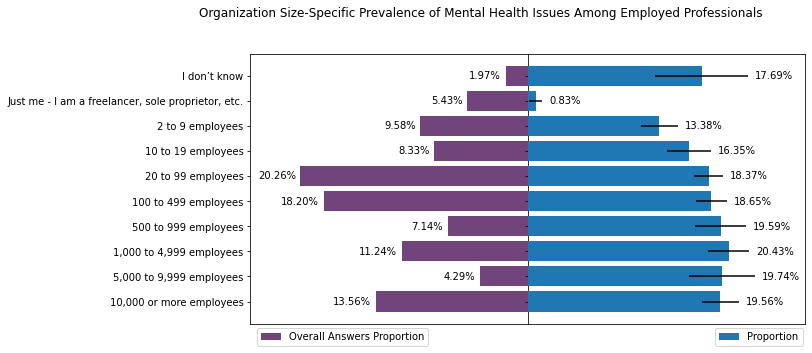

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()
fig.suptitle('Organization Size-Specific Prevalence of Mental Health Issues Among Employed Professionals')

axes[0].barh(df_mh_pro_org_size.index, -df_mh_pro_org_size['prop_all'], align='center', color='#71457C', zorder=10)
for i, v in enumerate(-df_mh_pro_org_size['prop_all']):
  axes[0].text(v-.004, i, f'{abs(v*100):.2f}%', color='black', ha='right', va='center', zorder=20)

axes[1].barh(df_mh_pro_org_size.index, df_mh_pro_org_size['prop_mh'], xerr=df_mh_pro_org_size['mh_conf_error'], align='center', zorder=10)
for i, v in enumerate(df_mh_pro_org_size[['prop_mh', 'mh_conf_error']].values):
  p = v[1]
  v = v[0]
  axes[1].text(v+p+.007, i, f'{v*100:.2f}%', color='black', ha='left', va='center', zorder=20)

plt.gca().invert_yaxis()

axes[0].set_xticks([])
axes[0].set_xticklabels([])
axes[1].set_xticks([])
axes[1].set_xticklabels([])

axes[0].margins(.22, .05)
axes[1].margins(.22, .05)

axes[0].legend(['Overall Answers Proportion'], fontsize=10, loc='lower left', bbox_to_anchor=(.005, -.10))
axes[1].legend(['Proportion'], fontsize=10, loc='lower right', bbox_to_anchor=(1.01, -.10))
plt.subplots_adjust(wspace=0, top=.85, bottom=.1, left=.18, right=.95)

In [ ]:
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older ',
    'Prefer not to say']

In [ ]:
df_mh_age = df_mh_pro['Age'].value_counts().reindex(age_order)
df_age = df['Age'].value_counts().reindex(age_order)
df_mh_pro_age = pd.concat([df_mh_age, df_age], axis=1)
df_mh_pro_age.columns = ['total_mh_samples', 'total_samples']
df_mh_pro_age.dropna(inplace=True)

In [ ]:
df_mh_pro_age['prop_all'] = df_mh_pro_age['total_samples'] / df_age.sum()
df_mh_pro_age['prop_mh'] = df_mh_pro_age['total_mh_samples'] / df_mh_pro_age['total_samples']

confidence_lvl_a = proportion_confint(df_mh_pro_age['total_mh_samples'], df_mh_pro_age['total_samples'])
df_mh_pro_age['mh_conf_lo'] = confidence_lvl_a[0]
df_mh_pro_age['mh_conf_hi'] = confidence_lvl_a[1]
df_mh_pro_age['mh_conf_error'] = confidence_lvl_a[1] - confidence_lvl_a[0]

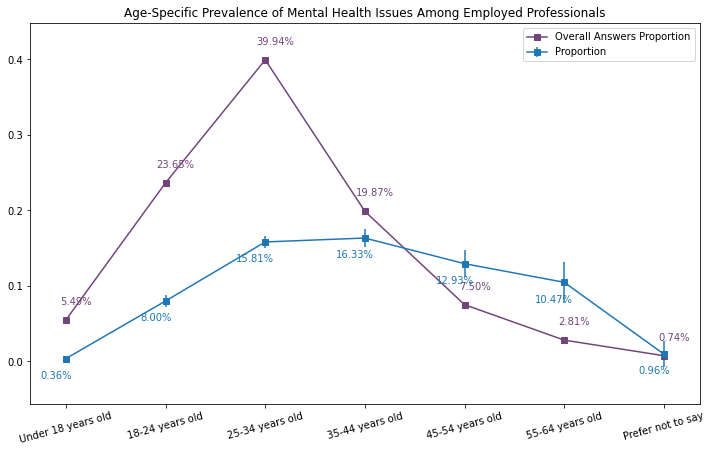

In [ ]:
xa = df_mh_pro_age.index
ya = df_mh_pro_age['prop_all']

xmh = df_mh_pro_age.index
ymh = df_mh_pro_age['prop_mh']
error = df_mh_pro_age['mh_conf_error']

plt.figure(figsize=(12,7))
plt.title('Age-Specific Prevalence of Mental Health Issues Among Employed Professionals')
plt.errorbar(xa, ya, fmt='-s', color='#71457C')
plt.errorbar(xmh, ymh, yerr=error, fmt='-s')
plt.legend(['Overall Answers Proportion', 'Proportion'], fontsize=10, loc='upper right')
plt.xticks(rotation = 15)
plt.margins(.06, .12)

for x, y in zip(xa, ya):
    label = f'{y*100:.2f}%'
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(10,15), ha='center', color='#71457C')

for x, y in zip(xmh, ymh):
    label = f'{y*100:.2f}%'
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(-10,-20), ha='center', color='#1f77b4')